In [117]:
import torch

import torch.nn as nn

import numpy as np

from tqdm.auto import tqdm

import matplotlib.pyplot as plt



import torchvision.datasets

In [118]:
CIFAR_TRAIN = torchvision.datasets.CIFAR10(root='./', train=True, download=True)

CIFAR_TEST = torchvision.datasets.CIFAR10(root='./', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [119]:
X_train, y_train = torch.tensor(CIFAR_TRAIN.data, dtype= torch.float32), torch.tensor(CIFAR_TRAIN.targets, dtype=torch.int8)

X_test, y_test = torch.tensor(CIFAR_TEST.data, dtype= torch.float32), torch.tensor(CIFAR_TEST.targets, dtype=torch.int8)

In [120]:
X_train = X_train.permute((0, 3, 1, 2))

X_test = X_test.permute((0, 3, 1, 2))

In [121]:
train_mean = torch.mean(X_train, 0)
train_std = X_train.std(dim=0)
test_mean = torch.mean(X_test, 0)
test_std = X_test.std(dim=0)

In [122]:
X_train = ( X_train - train_mean) / train_std

X_test = ( X_test - test_mean) / test_std

In [123]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [124]:
idx_to_class = {k : v for k, v in zip(np.arange(0, 11), CIFAR_TRAIN.classes)}

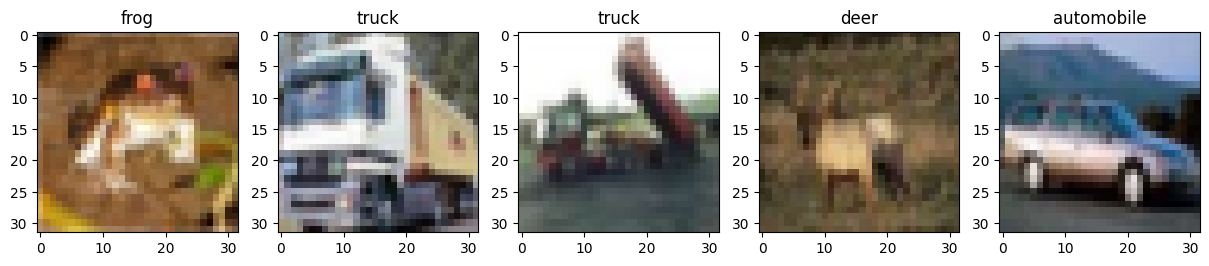

In [125]:
fig, ax = plt.subplots(1, 5, figsize=(15,4))

for i in range(5):

    ax[i].imshow((X_train[i] * train_std + train_mean).permute((1, 2, 0)).to(torch.int16))

    ax[i].title.set_text(idx_to_class[y_train[i].item()])

plt.show();

In [126]:
from torch.utils.data import DataLoader, TensorDataset

In [127]:
train_loader = DataLoader(

    TensorDataset(X_train, y_train), batch_size=500, pin_memory=True, shuffle=True, num_workers=3

)



test_loader = DataLoader(

    TensorDataset(X_test, y_test), batch_size=500, pin_memory=True, shuffle=True, num_workers=3

)

In [128]:
def acc_fn(y_true, y_preds):

    if y_true.shape != y_preds.shape:

        return ValueError("Wrong shapes y_true and y_preds")

    return torch.sum(y_true == y_preds) / len(y_true)

In [129]:
def plot_train_func(train_loss_hist, test_loss_hist, test_acc_hist):

    d = {

        0 : train_loss_hist,

        1 : test_loss_hist,

        2 : test_acc_hist

	}

    names = {

        0 : "Train loss",

        1 : "Test loss",

        2 : "Test accuracy"

    }

    fig, ax = plt.subplots(1, 3, figsize=(15,4))

    for i in range(3):

        ax[i].plot(d[i])

        ax[i].grid()

        ax[i].set_title(names[i])

    plt.show();

#### Define optimal model for CIFAR

In [130]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels = 1, out_channesl = 6, depth = 2):

        super().__init__()

        self.layers = nn.ModuleList()

        for i in range(depth):

            if i == 0:

                self.layers.append(nn.Conv2d(in_channels, out_channesl, 3, padding=1))

            else:

                self.layers.append(nn.Conv2d(out_channesl, out_channesl, 3, padding=1))

            self.layers.append(nn.ReLU(inplace=True))

            self.layers.append(nn.BatchNorm2d(out_channesl))

        self.layers.append(nn.MaxPool2d(2, 2))

    

    def forward(self, x):

        for layer in self.layers:

            x = layer(x)

        return x

In [131]:
class CifarModel(nn.Module):

    def __init__(self, in_channels = 3, out_classes = 10, hidden = 384):

        super().__init__()

        self.block1 = ConvBlock(in_channels, 12)  # 32 -> 16

        self.block2 = ConvBlock(12, 24)  # 16 -> 8

        self.block3 = ConvBlock(24, 48)  # 8 -> 4

        self.fc1 = nn.Linear(4 * 4 * 48, hidden)

        self.relu = nn.ReLU(inplace=True)

        self.bn = nn.BatchNorm1d(hidden)

        self.fc2 = nn.Linear(hidden, out_classes)

    

    

    def forward(self, x):

        x = self.block1(x)

        x = self.block2(x)

        x = self.block3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)

        x = self.relu(x)

        x = self.bn(x)

        return self.fc2(x)

In [179]:
def train_func(tr_l, ts_l, loss_fn, acc_fn, device, epochs=100, lr = 1e-4, model_class = None, model = None):

    if model_class == None and model == None:

        raise ValueError("Model empty")

    train_loss_hist = []

    test_loss_hist = []

    test_acc_hist = []

    

    if model == None:
        
        model = nn.DataParallel(model_class()).to(device)

    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)
    

    

    for epoch in tqdm(range(epochs)):

        model.train()

        train_loss = 0

        for X, y in tr_l:
            with torch.autograd.set_detect_anomaly(True):

                optimizer.zero_grad()
    
                X, y = X.to(device), y.type(torch.LongTensor).to(device)
    
                preds = model(X)
    
                loss = loss_fn(preds, y)
    
                loss.backward()
    
                optimizer.step()
    
                train_loss += loss.item()

        
        scheduler.step()
        
        train_loss /= len(tr_l)

        train_loss_hist.append(train_loss)



        


        model.eval()

        test_loss = 0

        test_acc = 0

        

        with torch.no_grad():

            for X, y in ts_l:

                X, y = X.to(device), y.type(torch.LongTensor).to(device)

                preds = model(X)

                test_loss += loss_fn(preds, y).item()

                test_acc += acc_fn(y, torch.argmax(preds, dim=1)).item()

        

        test_loss /= len(ts_l)

        test_acc /= len(ts_l)

        test_loss_hist.append(test_loss)

        test_acc_hist.append(test_acc)

        

        print(

            f"Epoch: {epoch}\ttrain loss: {loss}\ttest loss:{test_loss}\ttest acc:{test_acc}"

        )

    return (model, train_loss_hist, test_loss_hist, test_acc_hist)

In [180]:
loss_fn = torch.nn.CrossEntropyLoss()

In [181]:
trained_model, tr_loss_hist, ts_loss_hist, ts_acc_hist = train_func(train_loader, 

                                                            test_loader, loss_fn, 

                                                            acc_fn, device, 10, 3e-3, CifarModel)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	train loss: 1.0357179641723633	test loss:1.0517487943172454	test acc:0.625700032711029
Epoch: 1	train loss: 0.8059013485908508	test loss:0.8955449074506759	test acc:0.6885000318288803
Epoch: 2	train loss: 0.6533899903297424	test loss:0.8140628874301911	test acc:0.7179000318050385
Epoch: 3	train loss: 0.49020108580589294	test loss:0.6985283762216568	test acc:0.759300035238266
Epoch: 4	train loss: 0.4557966887950897	test loss:0.7091663748025894	test acc:0.7595000267028809
Epoch: 5	train loss: 0.3332682251930237	test loss:0.7202578574419022	test acc:0.7629000276327134
Epoch: 6	train loss: 0.2926916480064392	test loss:0.7077140569686889	test acc:0.7703000366687774
Epoch: 7	train loss: 0.25728392601013184	test loss:0.725177651643753	test acc:0.7677000313997269
Epoch: 8	train loss: 0.290046751499176	test loss:0.7462912112474441	test acc:0.7665000319480896
Epoch: 9	train loss: 0.1711626499891281	test loss:0.7492842972278595	test acc:0.7678000390529632


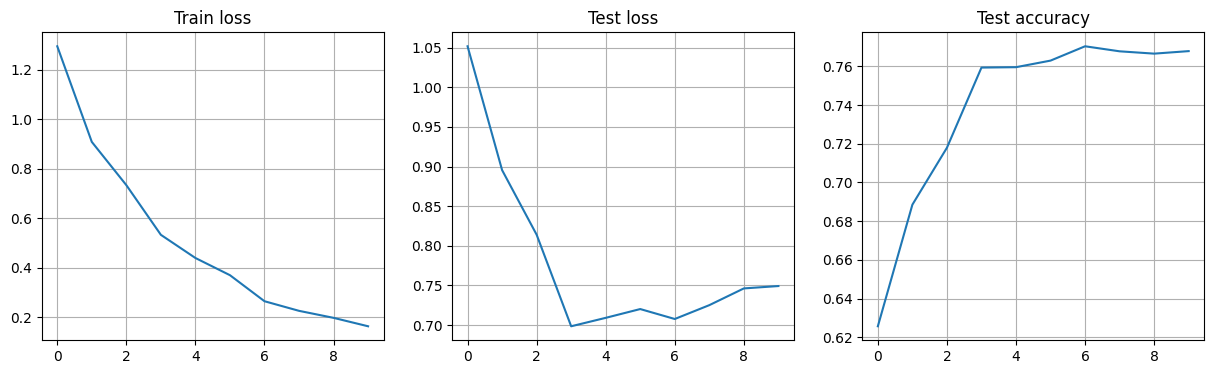

In [182]:
plot_train_func(tr_loss_hist, ts_loss_hist, ts_acc_hist)

In [183]:
test_acc = 0



with torch.no_grad():

                for X, y in test_loader:

                    X, y = X.to(device), y.to(device)

                    preds = trained_model(X)

                    test_acc += acc_fn(y, torch.argmax(preds, dim=1)).item()

                    

test_acc /= len(test_loader)

f"Accuracy: {test_acc}"

'Accuracy: 0.7678000360727311'

#### Let's define ResNet model to improve accuracy

In [184]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):

        super().__init__()

        self.downsample = downsample

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, 3, stride, padding=1),

            nn.BatchNorm2d(out_channels),

            self.relu,

        )

        self.conv2 = nn.Sequential(

            nn.Conv2d(out_channels, out_channels, 3, 1, padding=1),

            nn.BatchNorm2d(out_channels),

        )

    

    def forward(self, x):

        identity = x.clone()

        out = self.conv1(x)

        out = self.conv2(out)

        if self.downsample:

            identity = self.downsample(identity)

        out += identity

        out = self.relu(out)

        return out

In [185]:
class ResNet(nn.Module):

    def __init__(self, resblock, layers, out_classes):

        super().__init__()

        self.channesl = 64

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(

            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU()

        )

        self.mp = nn.MaxPool2d(2, 2)  # 32 -> 16



        self.layer1 = self.make_layer(resblock, 64, layers[0], 1)  # 16

        self.layer2 = self.make_layer(resblock, 128, layers[1], 2)  # 8

        self.layer3 = self.make_layer(resblock, 256, layers[2], 2)  # 4

        self.layer4 = self.make_layer(resblock, 512, layers[3], 2)  # 2

        self.pool = nn.AvgPool2d(2, 2)  # 1

        self.fc = nn.Linear(512, out_classes)



    def make_layer(self, block, channels, num_blocks, stride=1):

        downsample = None

        if stride != 1 or self.channesl != channels:

            downsample = nn.Sequential(

                nn.Conv2d(self.channesl, channels, 1, stride), nn.BatchNorm2d(channels)

            )



        layers = []

        for i in range(num_blocks):

            if i == 0:

                layers.append(block(self.channesl, channels, stride, downsample))

                self.channesl = channels

            else:

                layers.append(block(self.channesl, channels))



        return nn.Sequential(*layers)



    def forward(self, x):

        x = self.conv1(x)

        x = self.mp(x)

        

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.layer4(x)

        

        x = self.pool(x)

        

        x = x.view(x.size(0), -1)

        

        x = self.fc(x)

        return x

In [186]:
import gc



gc.collect()



torch.cuda.empty_cache()

In [187]:
model = nn.DataParallel(ResNet(ResBlock, [2, 2, 3, 2], 10)).to(device)

In [188]:
trained_model, tr_loss_hist, ts_loss_hist, ts_acc_hist = train_func(train_loader, 

                                                            test_loader, loss_fn, 

                                                            acc_fn, device, 15, 3e-3, model = model)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0	train loss: 1.1116236448287964	test loss:1.3197883129119874	test acc:0.5113000243902206
Epoch: 1	train loss: 0.8895497918128967	test loss:1.267719328403473	test acc:0.5778000295162201
Epoch: 2	train loss: 0.7525861859321594	test loss:0.8293859392404557	test acc:0.7146000355482102
Epoch: 3	train loss: 0.5075913667678833	test loss:0.6170141100883484	test acc:0.7840000361204147
Epoch: 4	train loss: 0.45441552996635437	test loss:0.646159878373146	test acc:0.7811000317335128
Epoch: 5	train loss: 0.4226253032684326	test loss:0.6940358102321624	test acc:0.779400035738945
Epoch: 6	train loss: 0.15190298855304718	test loss:0.6350308120250702	test acc:0.8095000356435775
Epoch: 7	train loss: 0.08032631129026413	test loss:0.7187135964632034	test acc:0.8085000336170196
Epoch: 8	train loss: 0.08351708948612213	test loss:0.8290941476821899	test acc:0.8035000383853912
Epoch: 9	train loss: 0.015941083431243896	test loss:0.8105223774909973	test acc:0.8137000352144241
Epoch: 10	train loss: 0.014

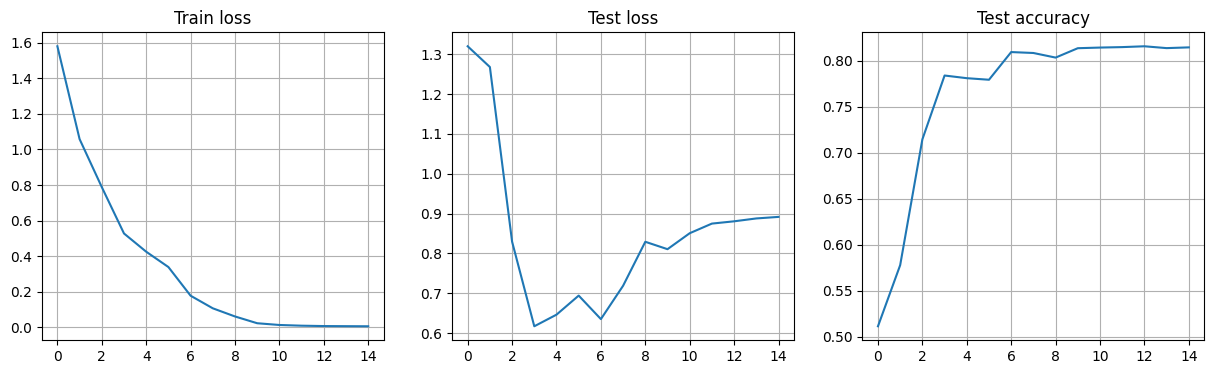

In [190]:
plot_train_func(tr_loss_hist, ts_loss_hist, ts_acc_hist)

#### ResNet showed better accuracy than the original convolutional model, as well as training was quite fast due to the use of Skip Connections